# River Tree

An example workflow for gathering NHD Plus data and generating a tree.  This tree can then be iterated over to accumulate data.  Braided systems are merged into a single reach, and the system is simplified relative to NHD Plus's raw format.

This type of workflow is useful for setting up stream network models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.config
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot

watershed_workflow.ui.setup_logging(1,None)

In [3]:
# open a shapefile for use here
shpfile = os.path.join('Coweeta', 'input_data', 'coweeta_basin.shp')
crs, shply = watershed_workflow.get_shapes(shpfile)
shply = shply[0]

2021-11-19 11:44:03,668 - root - INFO: 
2021-11-19 11:44:03,669 - root - INFO: Loading shapes
2021-11-19 11:44:03,670 - root - INFO: ------------------------------
2021-11-19 11:44:03,671 - root - INFO: Loading file: 'Coweeta/input_data/coweeta_basin.shp'
2021-11-19 11:44:03,686 - root - INFO: ... found 1 shapes
2021-11-19 11:44:03,687 - root - INFO: Converting to shapely


In [4]:
# find the rivers in this shape
_, reaches = watershed_workflow.get_reaches(watershed_workflow.source_list.hydrography_sources['NHD Plus'],
                                            '0601', shply.bounds, crs, crs, merge=False)

# filter the list to only those that intersect the shape
reaches = watershed_workflow.hydrography.filter_rivers_to_shape(shply, reaches, 10)

# make the global tree
rivers = watershed_workflow.hydrography.make_global_tree(reaches)

# check that only one tree was formed
assert(len(rivers) == 1)
river = rivers[0]

2021-11-19 11:44:03,727 - root - INFO: 
2021-11-19 11:44:03,728 - root - INFO: Loading Hydrography
2021-11-19 11:44:03,729 - root - INFO: ------------------------------
2021-11-19 11:44:03,730 - root - INFO: Loading streams in HUC 0601
2021-11-19 11:44:03,730 - root - INFO:          and/or bounds (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2021-11-19 11:44:03,734 - root - INFO:   Using Hydrography file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2021-11-19 11:44:03,735 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)'
2021-11-19 11:44:08,180 - root - INFO:   Filtering reaches not in-network
2021-11-19 11:44:08,180 - root - INFO: ... found 36 reac

found a zone: it is 17 of type <class 'int'>
{'zone': 17}
found a zone: it is 17 of type <class 'int'>
{'zone': 17}


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2021-11-10/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


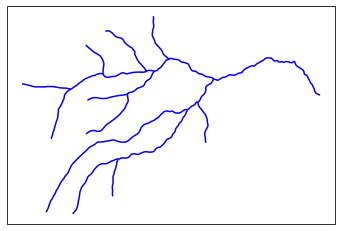

In [5]:
watershed_workflow.plot.rivers([river,], crs)

In [6]:
print('NAME: length')
print('-------------')
for r in river:
    print(f"{r.properties['GNIS_Name']}: {r.properties['Shape_Length']}")

NAME: length
-------------
Coweeta Creek: 0.02933313696587409
Ball Creek: 0.006007203236050549
Ball Creek: 0.0028292168551516204
Ball Creek: 0.020068080745982632
None: 0.007426501094440895
Ball Creek: 0.016249967638654387
Henson Creek: 0.03030158464830459
Henson Creek: 0.011012279803125276
None: 0.008785810565916707
Shope Fork: 0.011570165507744527
None: 0.009894541322192156
Shope Fork: 0.004264916720386313
Shope Fork: 0.0018043963180130245
Camprock Branch: 0.01301040698009797
Shope Fork: 0.010667588570320843
Shope Fork: 0.008081500797913782
Pinnacle Branch: 0.011390885255323774
Shope Fork: 0.01090783980118138
None: 0.007663308365762772
Cunningham Creek: 0.00785105614440285
Mill Branch: 0.00949783326393551
Cunningham Creek: 0.013625581127194461


In [7]:
import fiona
gdb = watershed_workflow.source_list.hydrography_sources['NHD Plus'].name_manager.file_name('0601')
fiona.listlayers(gdb)


['ExternalCrosswalk',
 'FeatureToMetadata',
 'HUMod',
 'NHDFCode',
 'NHDFeatureToMetadata',
 'NHDMetadata',
 'NHDPlusDivFracMP',
 'NHDPlusEROMMA',
 'NHDPlusEROMQAMA',
 'NHDPlusEROMQARPT',
 'NHDPlusFlow',
 'NHDPlusFlowlineVAA',
 'NHDPlusIncrLat',
 'NHDPlusIncrPrecipMA',
 'NHDPlusIncrPrecipMM01',
 'NHDPlusIncrPrecipMM02',
 'NHDPlusIncrPrecipMM03',
 'NHDPlusIncrPrecipMM04',
 'NHDPlusIncrPrecipMM05',
 'NHDPlusIncrPrecipMM06',
 'NHDPlusIncrPrecipMM07',
 'NHDPlusIncrPrecipMM08',
 'NHDPlusIncrPrecipMM09',
 'NHDPlusIncrPrecipMM10',
 'NHDPlusIncrPrecipMM11',
 'NHDPlusIncrPrecipMM12',
 'NHDPlusIncrROMA',
 'NHDPlusIncrTempMA',
 'NHDPlusIncrTempMM01',
 'NHDPlusIncrTempMM02',
 'NHDPlusIncrTempMM03',
 'NHDPlusIncrTempMM04',
 'NHDPlusIncrTempMM05',
 'NHDPlusIncrTempMM06',
 'NHDPlusIncrTempMM07',
 'NHDPlusIncrTempMM08',
 'NHDPlusIncrTempMM09',
 'NHDPlusIncrTempMM10',
 'NHDPlusIncrTempMM11',
 'NHDPlusIncrTempMM12',
 'NHDPlusMegaDiv',
 'NHDPlusNHDPlusIDGridCode',
 'NHDProcessingParameters',
 'NHDReachCo

In [8]:
with fiona.open(gdb, 'r', layer='NHDPlusFlowlineVAA') as fid:
    flowline = fid[10]
flowline

{'type': 'Feature',
 'id': '10',
 'properties': OrderedDict([('NHDPlusID', 25000400223214.0),
              ('StreamLeve', 7),
              ('StreamOrde', 1),
              ('StreamCalc', 1),
              ('FromNode', 25000400248803.0),
              ('ToNode', 25000400030593.0),
              ('HydroSeq', 25000400171446.0),
              ('LevelPathI', 25000400171446.0),
              ('PathLength', 1305.44034759),
              ('TerminalPa', 25000100000172.0),
              ('ArbolateSu', 0.28200000000000003),
              ('Divergence', 0),
              ('StartFlag', 1),
              ('TerminalFl', 0),
              ('UpLevelPat', 0.0),
              ('UpHydroSeq', 0.0),
              ('DnLevel', 6),
              ('DnLevelPat', 25000400058046.0),
              ('DnHydroSeq', 25000400108304.0),
              ('DnMinorHyd', 0.0),
              ('DnDrainCou', 1),
              ('FromMeas', 0.0),
              ('ToMeas', 100.0),
              ('ReachCode', '06010102005302'),
    